## download OSM files


 -> run commands in this cell from shell, not from notebook

cd /home/op/network_manila

#rm -rf data_osm_raw/

mkdir data_osm_raw

cd data_osm_raw

curl -O "http://download.geofabrik.de/asia/philippines-latest.osm.pbf"

cd ..

## import road data



In [3]:
import geopandas as gpd
import pandas as pd
import os, sys
import GOSTnets as gn
import importlib
from osgeo import ogr

In [56]:
cd /home/op/network_manila

/home/op/network_manila


In [ ]:
file = r'data_osm_raw/philippines-latest.osm.pbf' 
philippines = gn.OSM_to_network(file)

In [ ]:
#specify roads we want to keep and drop all others
accepted_road_types = ['residential', 'unclassified', 'track','service','tertiary',
                       'road','secondary','primary','trunk','primary_link','trunk_link',
                       'tertiary_link','secondary_link']
philippines.filterRoads(acceptedRoads = accepted_road_types)
philippines.roads_raw.infra_type.value_counts()

In [ ]:
#get administrative boundary of metro manila
philippines_adm2 = gpd.read_file("boundaries/philippines_adm2.geojson")
philippines_adm2 = philippines_adm2.to_crs({'init':'epsg:4326'})
manila = philippines_adm2[philippines_adm2.ADM2_NAME=="Metropolitan Manila"]
manila_geom = manila.geometry.unary_union
manila.plot()

In [ ]:
#keep only roads within the metro manila area
philippines.roads_raw = philippines.roads_raw.loc[
    philippines.roads_raw.geometry.intersects(manila_geom) == True]

In [ ]:
#generate road network geodataframe and graph objects
philippines.generateRoadsGDF(verbose = False)
philippines.initialReadIn()

In [ ]:
gn.save(philippines.network,'manila_unclean','data_osm_raw')

## clean network

In [4]:
import geopandas as gpd
import os, sys, time
import pandas as pd
import GOSTnets as gn
import importlib
import networkx as nx
import osmnx as ox
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

In [5]:
#https://epsg.io/3123
crs_manila = {'init': 'epsg:3123'}
crs_global = {'init': 'epsg:4326'}

In [56]:
cd /home/op/network_manila

/home/op/network_manila


In [6]:
G = nx.read_gpickle('data_osm_raw/manila_unclean.pickle')

In [7]:
G

In [9]:
#add metadata for osmnx plotting
G.graph.update( {'crs' : crs_manila} )
G.graph.update( {'name' : 'manila'} )
G.graph

{'crs': {'init': 'epsg:3123'}, 'name': 'manila'}

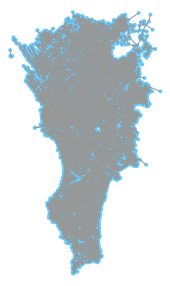

(<Figure size 201.56x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3e0a197710>)

In [10]:
ox.plot_graph(G, fig_height=5)

In [31]:
def print_changes(G,H):
    # print percentage change in number of edges and nodes between G(old graph) and H (new graph)
    
    hn = H.number_of_nodes()
    gn = G.number_of_nodes()
    he = H.number_of_edges()
    ge = G.number_of_edges()

    print("% change in # of nodes:", (hn-gn)/gn*100)
    print("% change in # of edges:", (he-ge)/ge*100)

In [42]:
def clean_network(G, crs_projected, crs_graph, thresh_combine_nodes):
    #bundles several cleanings steps into one function
    
    print("Before cleaning, graph has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")
    print("")
    print("1. Combine clusters of nodes into a single node if they are within the snapping tolerance of", 
          thresh_combine_nodes, "meters")
    H = gn.simplify_junctions(G, measure_crs = crs_projected, in_crs = crs_graph, 
                              thresh = thresh_combine_nodes)
    print_changes(G,H)
    print("")
    
    print("2. Ensure all streets are two-way by adding reflecting edges if they are missing")
    I = gn.add_missing_reflected_edges(H)
    print_changes(H,I)
    print("")
    
    print("3. Remove all nodes that are not intersections or dead-ends")
    J = gn.custom_simplify(I)
    print_changes(I, J)
    print("")
    
    # simplify the geometry type
    for u, v, data in J.edges(data = True):
        if type(data['Wkt']) == list:
                data['Wkt'] = gn.unbundle_geometry(data['Wkt'])
                
    # convert back to multidigraph
    K = gn.convert_to_MultiDiGraph(J)
    
    print("4. Remove duplicate edges, e.g. combining two lanes of the same road into one road")
    L = gn.remove_duplicate_edges(K)
    print_changes(K,L)
    print("")
    
    print("5. After removing duplicates, re-run steps 2 and 3")
    M = gn.custom_simplify(L)
    N = gn.add_missing_reflected_edges(M)
    print_changes(L, N)

    print("")
    print("After cleaning, graph has", N.number_of_nodes(), "nodes and", N.number_of_edges(), "edges")

    return N
    

In [43]:
G_clean = clean_network(G, crs_projected=crs_manila, crs_graph=crs_global, thresh_combine_nodes=5)


Before cleaning, graph has 108452 nodes and 143730 edges

1. Combine clusters of nodes into a single node if they are within the snapping tolerance of 5 meters
138067
% change in # of nodes: -5.584959244642791
% change in # of edges: -3.9400264384610035

2. Ensure all streets are two-way by adding reflecting edges if they are missing
273201
% change in # of nodes: 0.0
% change in # of edges: 97.87566905922486

3. Remove all nodes that are not intersections or dead-ends
% change in # of nodes: -12.327750378436447
% change in # of edges: -9.240815370368336

4. Remove duplicate edges, e.g. combining two lanes of the same road into one road
126277
% change in # of nodes: 0.0
% change in # of edges: -49.072613982375834

5. After removind duplicates, re-run steps 2 and 3
247696
% change in # of nodes: -0.015595063048612039
% change in # of edges: 96.1529019536416

After cleaining, graph has 89758 nodes and 247696 edges


In [44]:
gn.save(G_clean,'manila_clean','data_osm_raw')

In [45]:
G_cleaned = nx.read_gpickle('data_osm_raw/manila_clean.pickle')

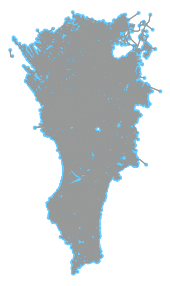

(<Figure size 201.56x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3da01fb978>)

In [47]:
#add metadata for osmnx plotting
G_cleaned.graph.update( {'crs' : crs_manila} )
G_cleaned.graph.update( {'name' : 'manila'} )
ox.plot_graph(G_cleaned, fig_height=5)